<center>
<h1>
Analyzing the Sentiment of Online Substance Abuse Support Groups During the
COVID-19 Pandemic via Natural Language Processing
</h1>   
<h5> 
<a href="https://www.google.com">Read the paper</a>
</h5>
</center>

# 1 Scraping / Data Collection

## 1.1 Installing dependencies and importing those for scraping

<p> Although not shown here, it is recommended that the following packages are installed in a conda virtual environment. The jupyter kernel also must be installed in the environment. </p>

In [3]:
!pip install -r requirements.txt

Looking in links: https://download.pytorch.org/whl/cu113


<hr>
PSAW (the Python PushShift API Wrapper) allows us to obtain historical posts, whereas PRAW does not have this functionality. PushShift is a third-party service that scrapes Reddit to provide "enhanced functionality and search capabilities for searching Reddit comments and submissions." Their API is intended research purposes.

PRAW (the Python Reddit API Wrapper) allows us to obtain the current "score" of a post, which is the total number of upvotes minus the total number of downvotes. Because PushShift scrapes posts only once (shortly after they are posted), the reported score is usually very low, as it is only accurate at the time they were scraped. Although PSAW lacks this functionality, it can be used in conjunction with PRAW, which solves this problem.

In [16]:
from calendar import monthrange
from collections import Counter

# the datetime object allows for easy chronological organization of the dataframe 
from datetime import datetime
import json

import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import os

# the data retrieved from the API is stored in a pandas dataframe
import pandas as pd

# python wrapper for the official reddit api
import praw 

# python wrapper for the pushshift api
from psaw import PushshiftAPI 

import random
import statistics
import sys
import time

[nltk_data] Downloading package stopwords to /home/zeyad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeyad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1.2 Authenticating with the Reddit API 

In order to use the Reddit API, one must apply to be granted access for use with their account. After agreeing with the ToS, one can apply [here](https://docs.google.com/forms/d/e/1FAIpQLSezNdDNK1-P8mspSbmtC2r86Ee9ZRbC66u929cG2GX0T9UMyw/viewform).
Then, we can authenticate with PRAW with the credentials that we provide in the [client_secrets.json](client_secrets.jsonclient_secrets.jsonclient_secrets.json) file.

In [9]:
# client_secrets.json file must be created to contain credentials
# ex_client_secrets.json contains the example credentials format
f = open('client_secrets.json') 
 
client_secrets = json.load(f)

r = praw.Reddit(client_id=client_secrets["client_id"],
    client_secret=client_secrets["client_secret"],
    username=client_secrets["username"],
    password=client_secrets["password"],
    user_agent=client_secrets["user_agent"]
)

api = PushshiftAPI(r)

## 1.3 Scraping via Requests to the API 

We define a list of the subreddits that we want to scrape, and intitalize the approaptite time interval variables.

In [17]:
subreddits = ["addiction", "alcoholism", "benzorecovery", "leaves", "OpiatesRecovery", "quittingkratom", 
              "QuittingPhenibut", "redditorsinrecovery",  "StopDrinking", "StopSmoking", "StopSpeeding"]  
start_year = 2019
start_month = 10
end_year = 2022
end_month = 2

The following cell contains helper functions for future steps.

In [18]:
def save_posts_by_month(subreddit, year, month, limit=100000):
    ''' 
    Scrapes and saves all posts from the specified subreddit to a CSV file
    given a particular month in the "year-month" format
    '''
    num_days = monthrange(year, month)[1]
    after=int(datetime(year, month, 1).timestamp())
    before=int(datetime(year, month, num_days).timestamp()) 
    print(f"Scraping posts from /r/{subreddit} [{year}, {month}]...")
    gen = api.search_submissions(after=after, before=before, subreddit=subreddit, limit=limit)
    post_list = []
    for e in gen:
        submission = r.submission(e)
        post_list.append({"Date": datetime.fromtimestamp(submission.created_utc), "URL": submission.url, "Title": submission.title, "Body": submission.selftext, "Score": submission.score})
        
    df = pd.DataFrame(post_list)
    df.to_csv(f"data/{subreddit}/{subreddit}_{year}-{month}.csv", index = False, header = True)
    
def iter_months(start_year, start_month, end_year, end_month):
    ''' 
    Yields the dates of months in the "year-month" format given time interval 
    '''   
    while (start_year == end_year and start_month <= end_month) or (start_year < end_year):
        if start_month < 12:
            yield {"year":start_year, "month":start_month}
            start_month += 1
        else:
            yield {"year":start_year, "month":start_month}
            start_year += 1
            start_month = 1

We want to be able to permanently store the data that we scrape for future analysis. 

The scraping process can be lengthly due to rate limiting, and storing the data we get from the API in memory is bad practice when considering the likelihood of an unexpected crash. Therefore, for each subreddit, after each month of posts we scrape, we save the pandas dataframe to the disk in the .csv file format.

In [19]:
def scrape_posts(subreddits, start_year, start_month, end_year, end_month):
    print(f"{len(subreddits)} subreddits selected")

    datadir = 'data'
    try:
        os.mkdir('data')
        print(f"Directory '{datadir}' was created") 
    except FileExistsError:
        print(f"Directory '{datadir}' already exists")
        
    for subreddit in subreddits:
        datadir = f"data/{subreddit}"
        try:
            os.mkdir(datadir)
            print(f"Directory '{datadir}' was created") 
        except FileExistsError:
            print(f"Directory '{datadir}' already exists")
            continue
            
        for date in iter_months(start_year, start_month, end_year, end_month):
            save_posts_by_month(subreddit, date["year"], date["month"])
       

scrape_posts(subreddits, start_year, start_month, end_year, end_month)

11 subreddits selected
Directory 'data' already exists
Directory 'data/addiction' already exists
Directory 'data/alcoholism' already exists
Directory 'data/benzorecovery' already exists
Directory 'data/leaves' already exists
Directory 'data/OpiatesRecovery' already exists
Directory 'data/quittingkratom' already exists
Directory 'data/QuittingPhenibut' already exists
Directory 'data/redditorsinrecovery' already exists
Directory 'data/StopDrinking' already exists
Directory 'data/StopSmoking' already exists
Directory 'data/StopSpeeding' already exists


Posts that were deleted, and contain little to no data, are still returned. We want to remove these from our dataset. To do this, we search each post for the keywords "deleted" or "removed" and remove those posts.

In [20]:
#Delete the posts that were either deleted or removed
deleted_keywords = ["deleted", "removed"]

for subreddit in subreddits: 
    for date in iter_months(start_year, start_month, end_year, end_month): 
        filename = f'data/{subreddit}/{subreddit}_{date["year"]}-{date["month"]}.csv'
        indicies_to_delete = list()
        df = pd.read_csv(filename) 
        for index, row in df.iterrows():
            for e in deleted_keywords:
                if e in str(row["Title"]) or e in str(row["Body"]):
                    indicies_to_delete.append(index)
                    
        df = df.drop(labels=indicies_to_delete, axis=0)
        df = df.reset_index()
        df = df.drop(labels="index", axis=1)
        df.to_csv(filename, index=False)

print("Finished removing the posts that were either deleted or removed.")

Finished removing the posts that were either deleted or removed.


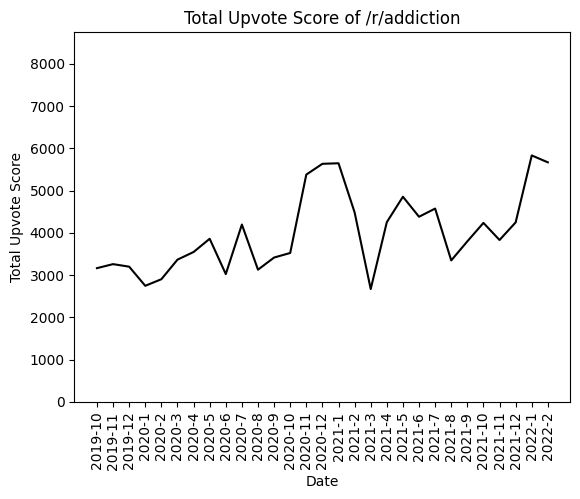

In [26]:
plt.style.use('default')

#only plot one subreddit since this is for demonstration
for subreddit in ["addiction"]: 
    dates = list()
    scores_stat = list()
    for date in iter_months(start_year, start_month, end_year, end_month): 
        score_list = list()
        df = pd.read_csv(f'data/{subreddit}/{subreddit}_{date["year"]}-{date["month"]}.csv')
        for index, row in df.iterrows():
            score_list.append(row["Score"])
        scores_stat.append(sum(score_list))
        dates.append(f'{date["year"]}-{date["month"]}')             
    x = dates
    y = scores_stat
    plt.xticks(rotation=90)
    plt.xlabel('Date')
    plt.ylabel('Total Upvote Score')
    plt.title(f'Total Upvote Score of /r/{subreddit}')
    plt.ylim(ymin=0, ymax = max(y)*1.5)
    plt.plot(x, y, color='black');
    plt.show()

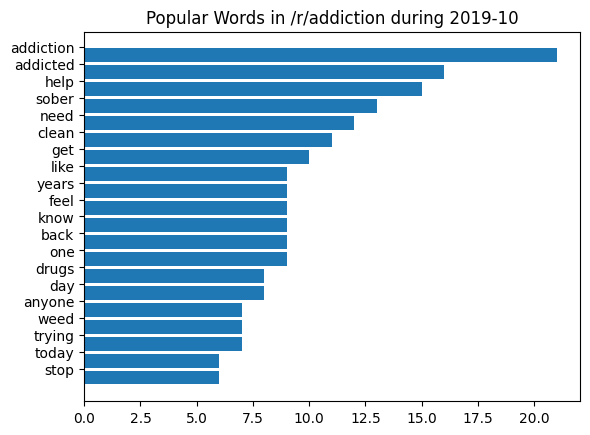

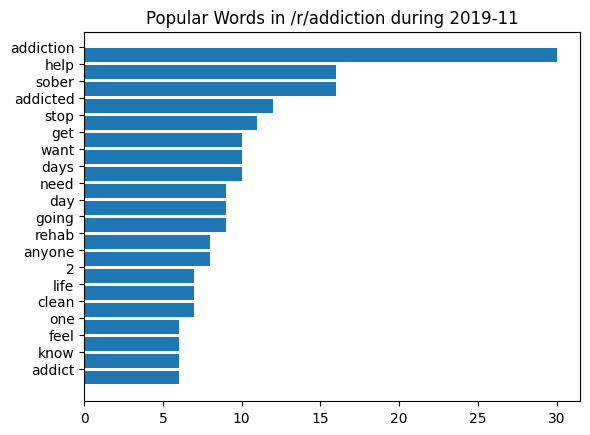

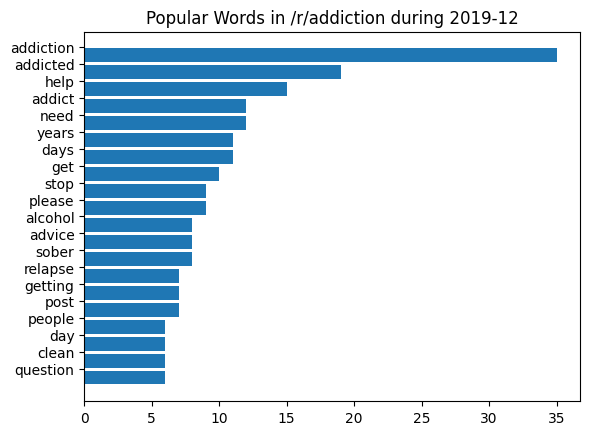

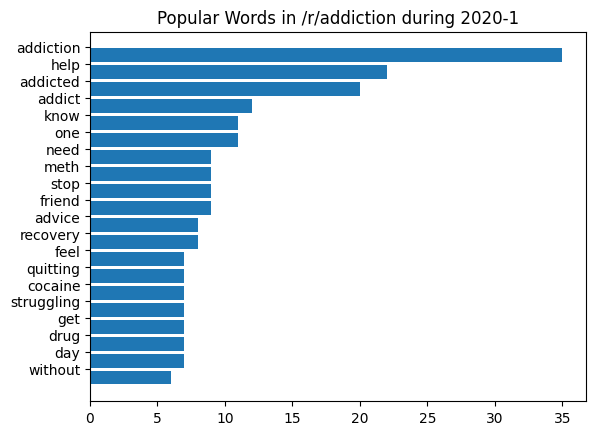

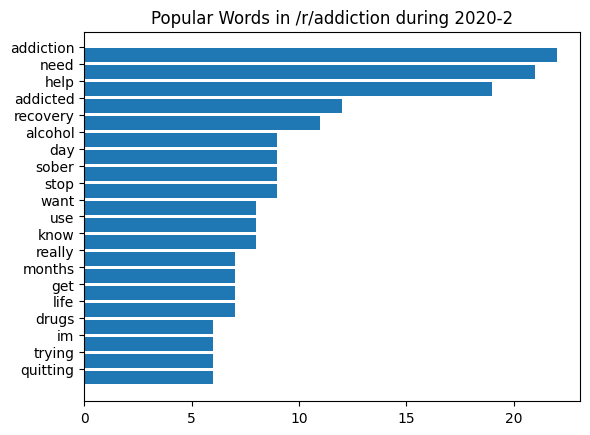

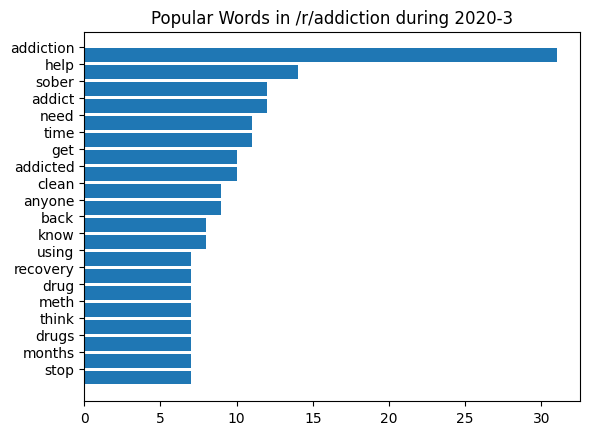

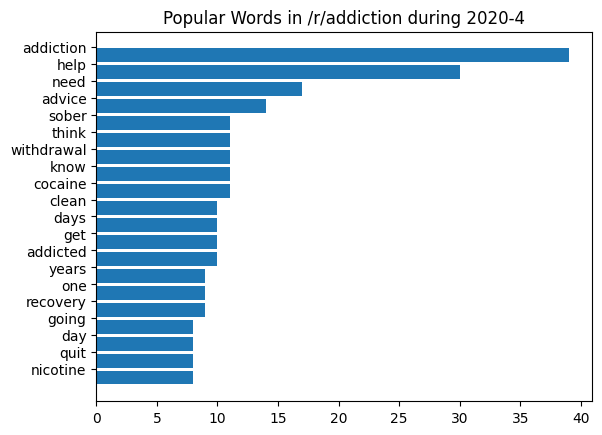

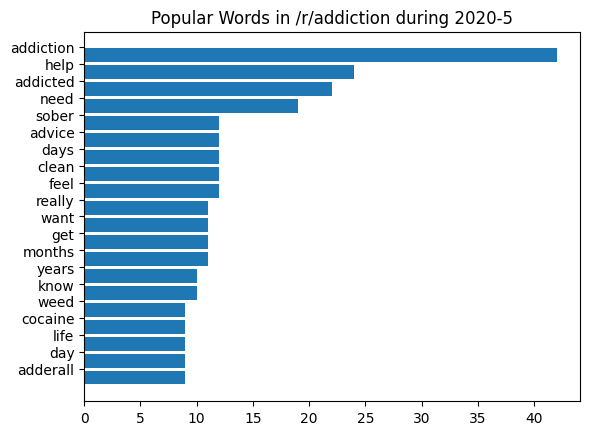

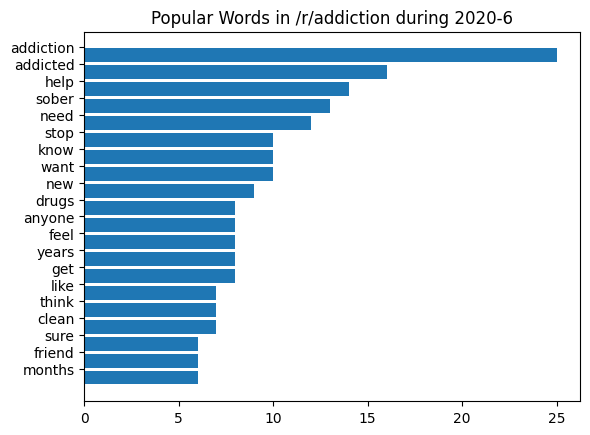

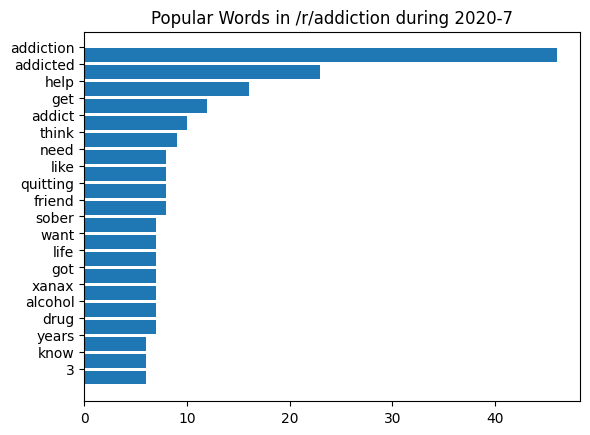

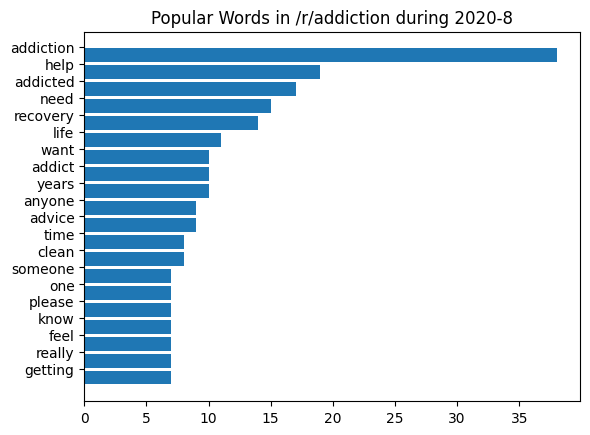

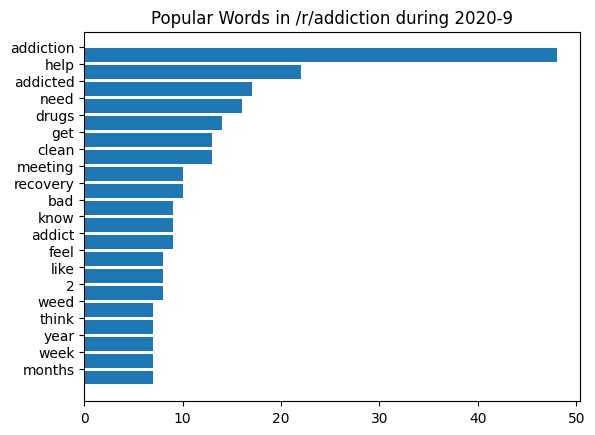

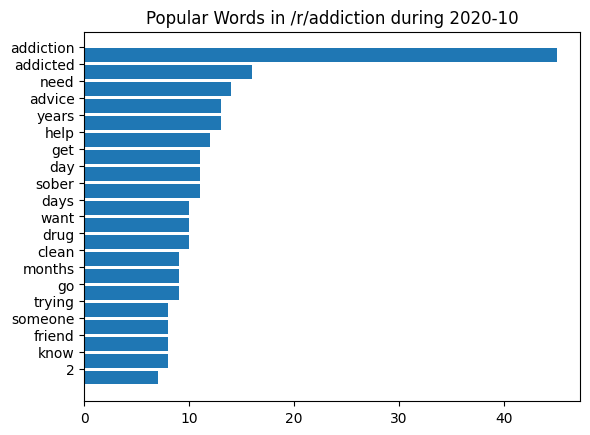

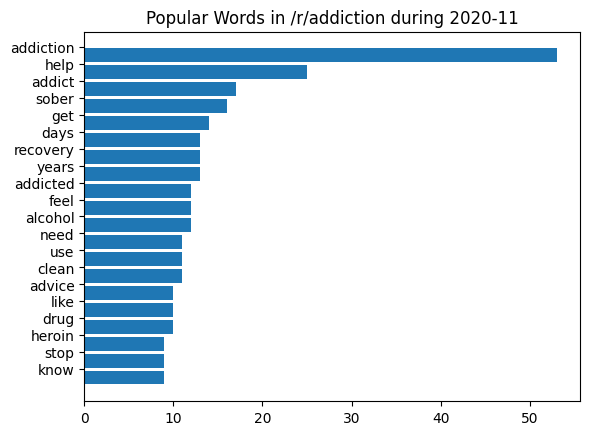

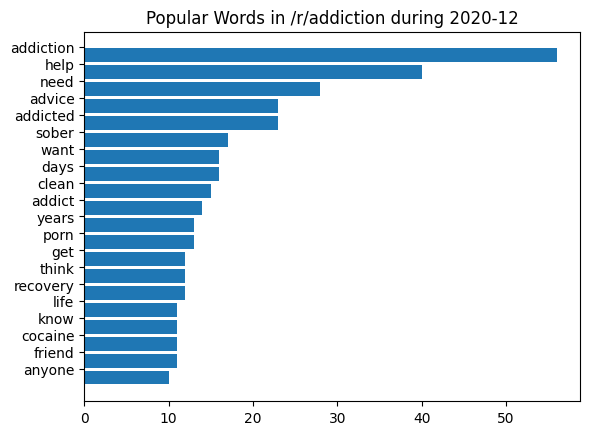

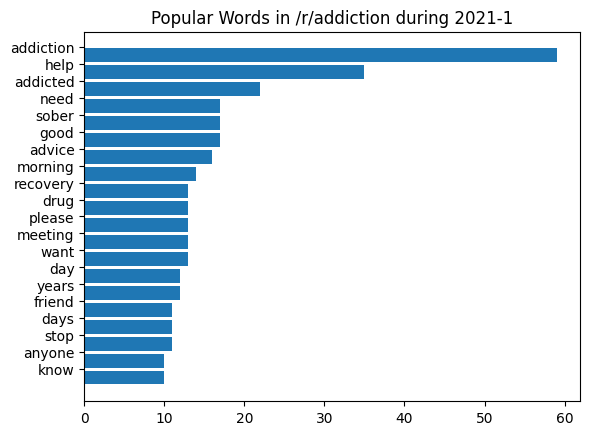

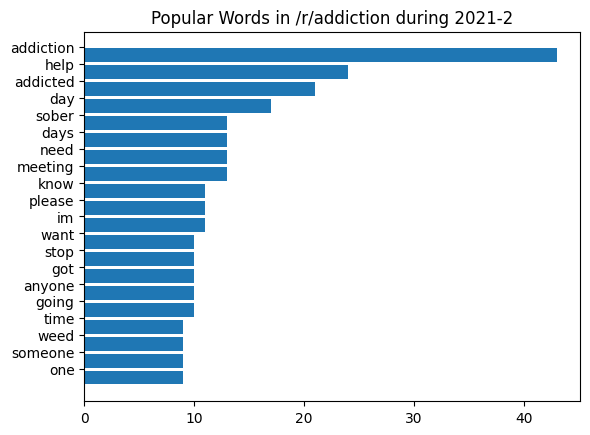

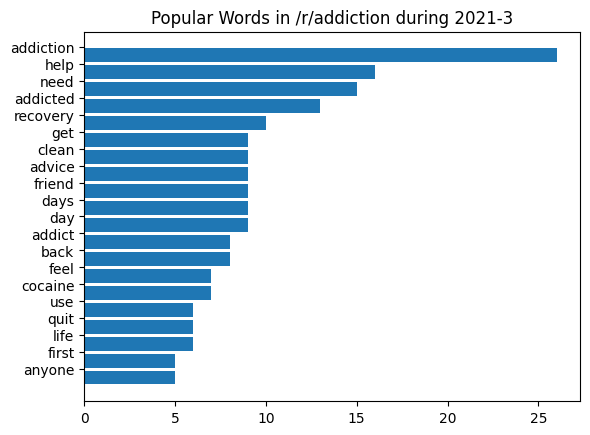

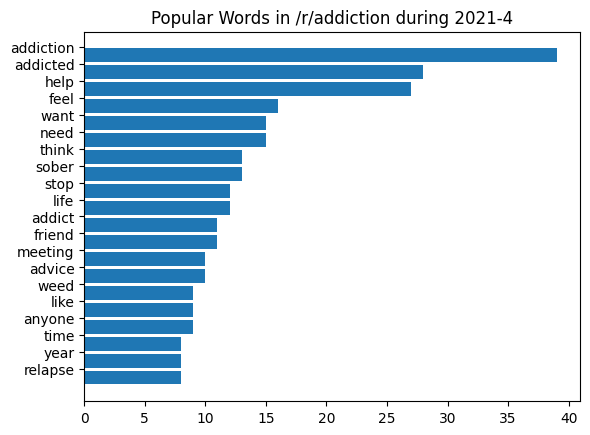

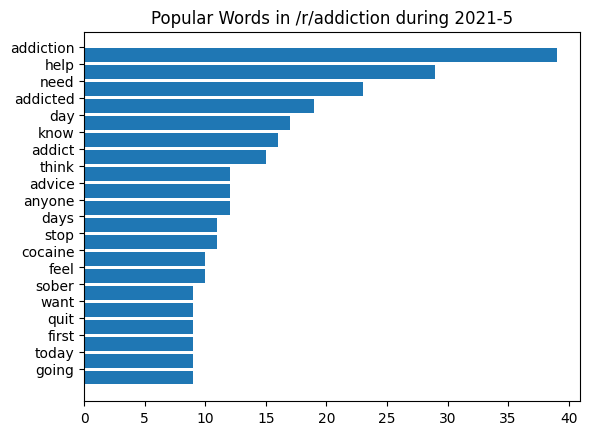

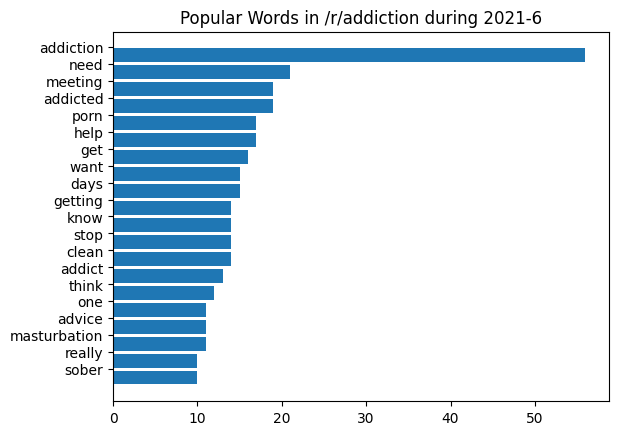

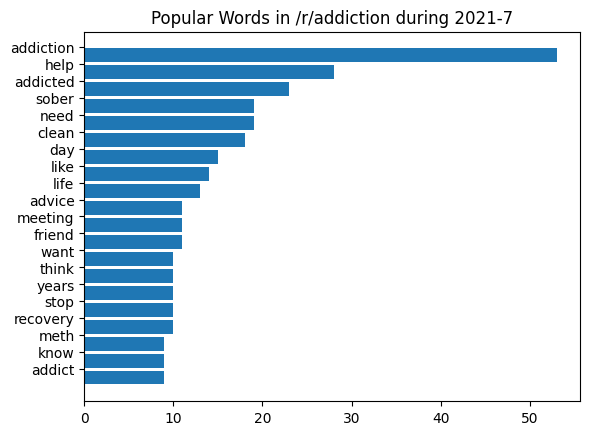

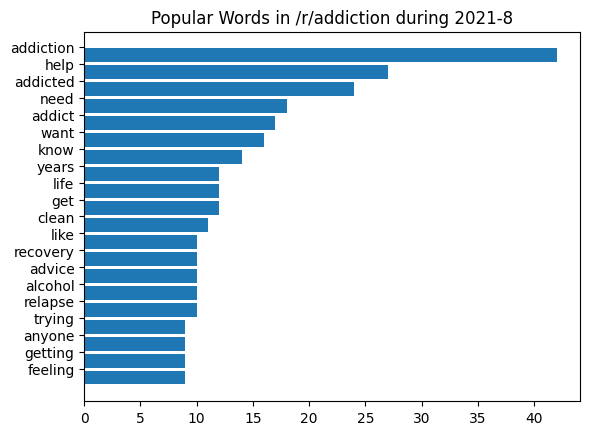

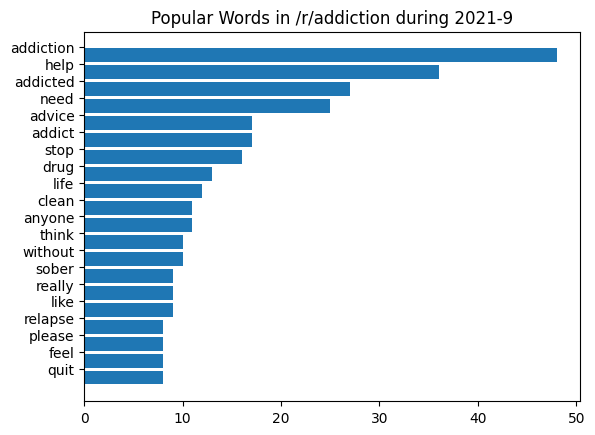

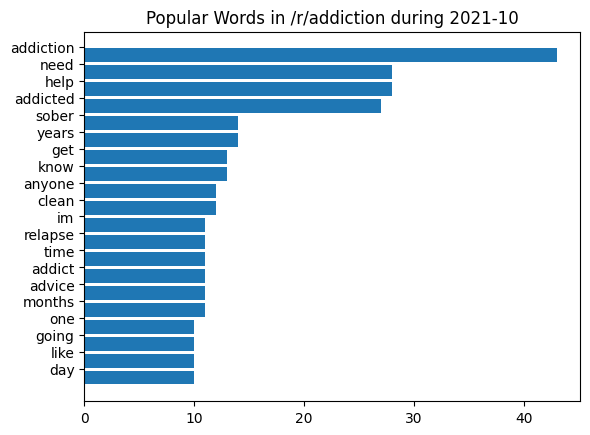

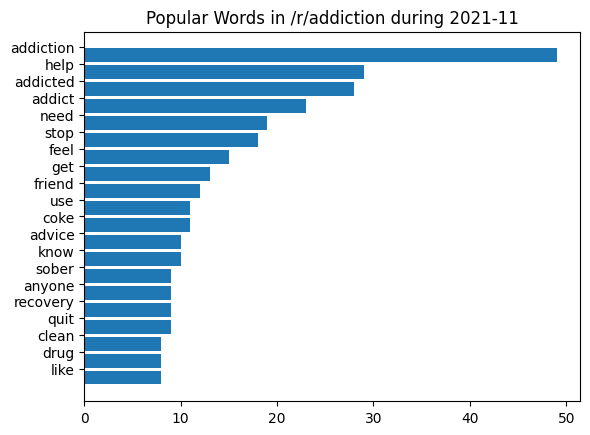

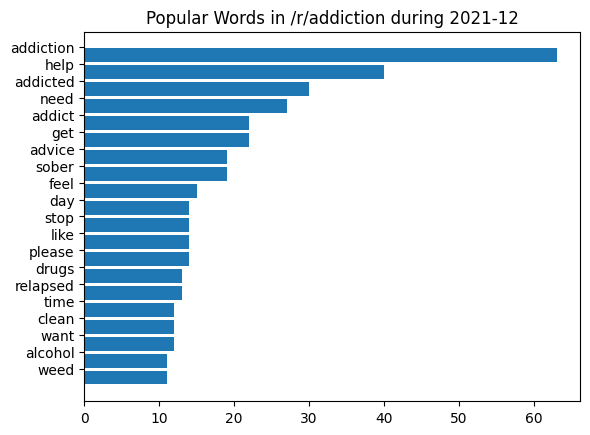

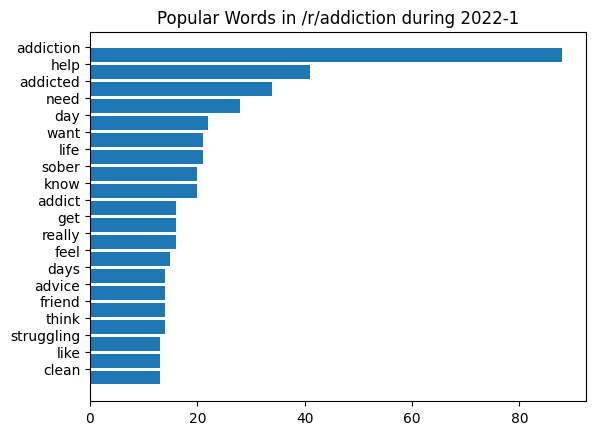

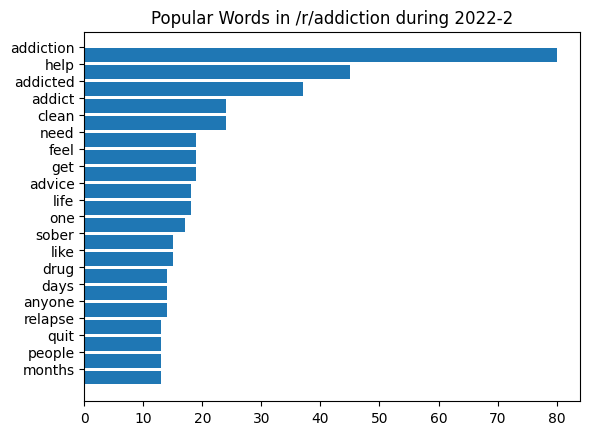

In [30]:
stopwords_set = stopwords.words('english')

def wordBarGraph(df,column,title):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords_set and w.isalnum()]
    plt.barh(range(20), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:20])])
    plt.yticks([x + 0.5 for x in range(20)], reversed(popular_words_nonstop[0:20]))
    plt.title(title)
    plt.show()
    
    
for subreddit in ["addiction"]: 
    for date in iter_months(start_year, start_month, end_year, end_month): 
        df = pd.read_csv(f'data/{subreddit}/{subreddit}_{date["year"]}-{date["month"]}.csv')
        plt.figure()
        wordBarGraph(df,'Title',f"Popular Words in /r/{subreddit} during {date['year']}-{date['month']}")
    
    


In [ ]:
from transformers import AlbertTokenizer, AlbertModel
import torch

tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
model = AlbertModel.from_pretrained("albert-base-v2")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state